In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
import copy
import math
import random
import time
import re
import graphviz
import ast
import sys
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

In [2]:
data = pd.read_csv('train_clean.csv', index_col=0)
data_test = pd.read_csv('test_clean.csv', index_col=0)
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Unknown,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Unknown,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Unknown,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Unknown,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Unknown,S


In [3]:
data_label = data['Survived']
data_train = data.drop('Survived', axis=1)
data_train.shape, data_test.shape

((891, 11), (418, 11))

In [4]:
full_data = data.append(data_test, ignore_index=True, sort=False)
full_data = full_data.fillna(-1)
full_data['Survived'] = full_data['Survived'].apply(int)

In [5]:
def getTitle(name):
    title = re.search(' ([A-Za-z]+)\.', name)
    if title:
        return title.group(1)
    return ''

def groupTitles(title):
    rares = ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
    if title in rares:
        title = 'Rare'
    title = title.replace('Mlle', 'Miss')
    title = title.replace('Ms', 'Miss')
    title = title.replace('Mme', 'Mrs')
    return title

def get_LastName(name):
    words = name.split()
    last_name = ''
    flag = False
    for word in words:
        if word[0] == '(':
            break
        if flag:
            last_name += word + ' '
        if word[-1] == '.':
            flag = True
    return last_name[:-1]

def getLastName(name):
    return name.split()[0][:-1]
        
def shift_0_age(age):
    if age == 0:
        return 30
    else:
        return age

def shift_30_age_master(age, title):
    if age == 0:
        if title == 'Master':
            return 10
        else:
            return 30
    else:
        return age
    
def getTicketGroup(ticket):
    return full_data[full_data['Ticket'] == ticket].shape[0]

def getTicketGroupSurvival(ticket):
    return 0

def getSexChild(sex, age):
    if age <= 15:
        return 2
    else:
        return int(sex == 'female')
    
def getFullGroup(ticket):
    group = full_data[full_data['Ticket'] == ticket]
    
    return int(len(group['SexChild'].unique()) == 3)

def getFullFamily(last_name):
    group = full_data[full_data['Last Name'] == last_name]
    
    return int(len(group['SexChild'].unique()) == 3)

def getFareAdjasted(fare, ticket_group):
    return fare/float(ticket_group)

In [6]:
full_data['Title'] = full_data['Name'].apply(getTitle)
full_data['Title'] = full_data['Title'].apply(groupTitles)
full_data['Last Name'] = full_data['Name'].apply(getLastName)
full_data['Family_size'] = full_data['SibSp'] + full_data['Parch'] + 1
full_data['isAlone'] = (full_data['Family_size'] == 1).apply(int)
full_data['Ticket_group'] = full_data['Ticket'].apply(getTicketGroup)
full_data['isAlone2'] = (full_data['Ticket_group'] == 1).apply(int)
full_data['Age'] = full_data[['Age', 'Title']].apply(lambda row: shift_30_age_master(row['Age'], row['Title']), axis=1)
full_data['SexChild'] = full_data[['Sex', 'Age']].apply(lambda row: getSexChild(row['Sex'], row['Age']), axis=1)
full_data['full_group'] = full_data['Ticket'].apply(getFullGroup)
full_data['full_family'] = full_data['Last Name'].apply(getFullFamily)
full_data['hasCabin'] = (full_data['Cabin'] != 'Unknown').apply(int)
full_data['Fare_adj'] = full_data[['Fare',
                                   'Ticket_group']].apply(lambda row:getFareAdjasted(row['Fare'], row['Ticket_group']), axis=1)

In [7]:
full_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Last Name',
       'Family_size', 'isAlone', 'Ticket_group', 'isAlone2', 'SexChild',
       'full_group', 'full_family', 'hasCabin', 'Fare_adj'],
      dtype='object')

In [8]:
train_d = full_data[full_data['Survived']>=0].copy()
test_d = full_data[full_data['Survived'] == 0].copy()
train_d.shape

(891, 23)

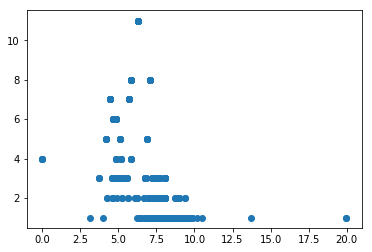

In [9]:
plot_data = full_data[full_data['Pclass'] == 3]
plt.scatter(plot_data['Fare_adj'], plot_data['Ticket_group'])
plt.show()

(0, 200)

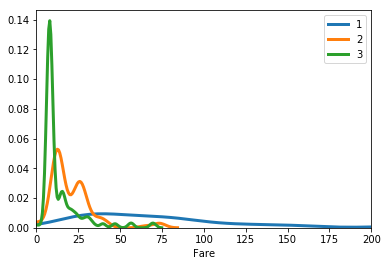

In [10]:
for pclass in range(1,4):
    subset = train_d[train_d['Pclass'] == pclass]
    sns.distplot(subset['Fare'], hist=False, kde=True
                , kde_kws={'linewidth':3}, label=pclass)  
plt.xlim(0,200)

(0, 50)

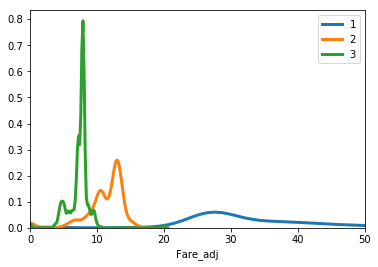

In [11]:
for pclass in range(1,4):
    subset = train_d[train_d['Pclass'] == pclass]
    sns.distplot(subset['Fare_adj'], hist=False, kde=True
                , kde_kws={'linewidth':3}, label=pclass)  
plt.xlim(0,50)

In [12]:
full_data.shape

(1309, 23)

In [13]:
family_data = full_data[full_data['full_family'] == 1]
family_data.shape

(167, 23)

In [14]:
family_data[family_data['Survived'] == -1].shape

(52, 23)

In [15]:
def get_family_survival(last_name, sexChild):
    group = full_data[full_data['Last Name'] == last_name]
    group = group[(group['SexChild'] == sexChild) & (group['Survived'] >= 0)]
    if group.shape[0] == 0:
        return -1
    else:
        return group['Survived'].mean()
    
def get_male_survival(last_name):
    return get_family_survival(last_name, 0)

def get_female_survival(last_name):
    return get_family_survival(last_name, 1)

def get_child_survival(last_name):
    return get_family_survival(last_name, 2)

In [16]:
full_data['M Survival'] = full_data['Last Name'].apply(get_male_survival)
full_data['F Survival'] = full_data['Last Name'].apply(get_female_survival)
full_data['C Survival'] = full_data['Last Name'].apply(get_child_survival)

In [17]:
full_data[full_data['full_family'] == 1].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Ticket_group,isAlone2,SexChild,full_group,full_family,hasCabin,Fare_adj,M Survival,F Survival,C Survival
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,...,3,0,1,0,1,0,3.711100,0.0,1.0,1.000000
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,...,7,0,0,1,1,0,4.467857,0.5,0.5,0.000000
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,...,7,0,1,1,1,0,4.483929,-1.0,1.0,0.666667
43,44,1,2,"Laroche, Miss. Simonne Marie Anne Andree",female,3.0,1,2,SC/Paris 2123,41.5792,...,4,0,2,1,1,0,10.394800,0.0,1.0,1.000000
50,51,0,3,"Panula, Master. Juha Niilo",male,7.0,4,1,3101295,39.6875,...,7,0,2,1,1,0,5.669643,0.0,0.0,0.000000


In [18]:
full_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Last Name',
       'Family_size', 'isAlone', 'Ticket_group', 'isAlone2', 'SexChild',
       'full_group', 'full_family', 'hasCabin', 'Fare_adj', 'M Survival',
       'F Survival', 'C Survival'],
      dtype='object')

In [19]:
train_d = full_data[full_data['Survived']>=0].copy()
test_d = full_data[full_data['Survived'] == 0].copy()
train_d.shape

(891, 26)

In [20]:
temp = train_d[(train_d['C Survival'] == 0)]
temp.groupby('SexChild')['Survived'].count()

SexChild
0    13
1    20
2    34
Name: Survived, dtype: int64

In [21]:
def get_family_survival(passId, last_name):
    group = full_data[(full_data['Last Name'] == last_name) & (full_data['PassengerId'] != passId)]
    group = group[(group['Survived'] >= 0)]
    if group.shape[0] == 0:
        return -1
    else:
        return group['Survived'].mean()
    
def get_ticket_survival(passId, ticket):
    group = full_data[(full_data['Ticket'] == ticket) & (full_data['PassengerId'] != passId)]
    group = group[(group['Survived'] >= 0)]
    if group.shape[0] == 0:
        return -1
    else:
        return group['Survived'].mean()
    

In [65]:
full_data['Family Survival'] = full_data[['PassengerId', 'Last Name']].apply(
    lambda row: get_family_survival(row['PassengerId'], row['Last Name']), axis=1)
full_data['Ticket Survival'] = full_data[['PassengerId', 'Ticket']].apply(
    lambda row: get_ticket_survival(row['PassengerId'], row['Ticket']), axis=1)

In [23]:
full_data[abs(full_data['Family Survival'] - full_data['Ticket Survival']) > 0.1].shape

(335, 28)

In [24]:
full_data[full_data['Family Survival'] >= 0].shape

(556, 28)

In [25]:
full_data[full_data['Ticket Survival'] >= 0].shape

(496, 28)

In [26]:
train_d = full_data[full_data['Survived']>=0].copy()
test_d = full_data[full_data['Survived'] == 0].copy()
train_d.shape

(891, 28)

([array([23.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
  array([ 6.,  1.,  0.,  3.,  1.,  8.,  2.,  0.,  0., 17.])],
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 Lists of Patches objects>)

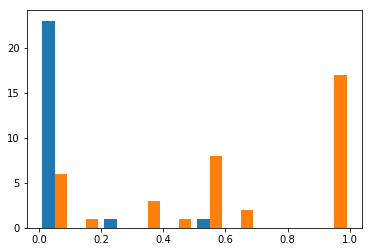

In [27]:
to_plot = full_data[(full_data['SexChild'] == 1) & (full_data['Family Survival'] >= 0) & (full_data['Family_size'] > 2)]
#for surv in range(2):
    #sns.distplot(to_plot[to_plot['Survived'] == surv]['Family Survival'], hist=False, label=surv)
    #to_plot[to_plot['Survived'] == surv]['Family Survival'].hist()

plt.hist([to_plot[to_plot['Survived'] == 0]['Family Survival'], to_plot[to_plot['Survived'] == 1]['Family Survival']])

([array([23.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]),
  array([ 6.,  0.,  0.,  2.,  0.,  7.,  2.,  0.,  0., 20.])],
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 Lists of Patches objects>)

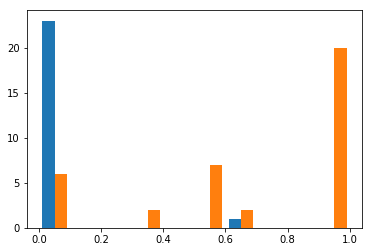

In [28]:
to_plot = full_data[(full_data['SexChild'] == 1) & (full_data['Ticket Survival'] >= 0) & (full_data['Family_size'] > 2)]

plt.hist([to_plot[to_plot['Survived'] == 0]['Ticket Survival'], to_plot[to_plot['Survived'] == 1]['Ticket Survival']])

In [30]:
full_data['Group Survival'] = full_data[['Family Survival', 'Ticket Survival']].apply(max, axis=1)
full_data.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,full_group,full_family,hasCabin,Fare_adj,M Survival,F Survival,C Survival,Family Survival,Ticket Survival,Group Survival
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,...,0,0,0,7.25,0.0,-1.0,-1.0,0.0,-1.0,0.0


In [31]:
full_data[full_data['Group Survival'] >= 0].shape

(664, 29)

([array([20.,  0.,  1.,  0.,  0.,  1.,  2.,  0.,  0., 17.]),
  array([0., 0., 0., 0., 0., 0., 1., 0., 0., 5.])],
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 Lists of Patches objects>)

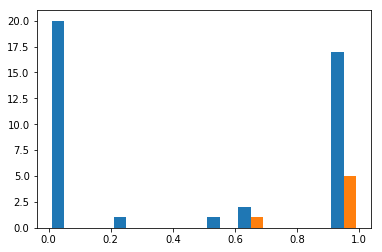

In [32]:
to_plot = full_data[(full_data['SexChild'] == 0) & (full_data['Group Survival'] >= 0) & (full_data['Family_size'] > 2)]

plt.hist([to_plot[to_plot['Survived'] == 0]['Group Survival'], to_plot[to_plot['Survived'] == 1]['Group Survival']])

([array([94.,  0.,  1.,  7.,  0., 12.,  4.,  0.,  2., 52.]),
  array([ 5.,  1.,  0.,  1.,  0.,  1.,  6.,  0.,  0., 19.])],
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 Lists of Patches objects>)

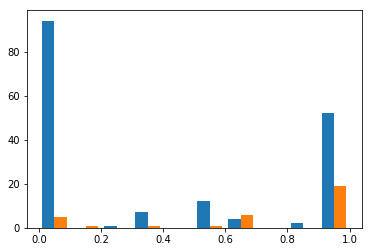

In [33]:
to_plot = full_data[(full_data['SexChild'] == 0) & (full_data['Group Survival'] >= 0)]

plt.hist([to_plot[to_plot['Survived'] == 0]['Group Survival'], to_plot[to_plot['Survived'] == 1]['Group Survival']])

In [39]:
to_plot[(to_plot['Survived'] == 1) & (to_plot['Group Survival'] == 0)][['Last Name', 'Ticket']]

,Last Name,Ticket
17,Williams,244373
207,Albimona,2699
271,Tornquist,LINE
572,Flynn,PC 17474
579,Jussila,STON/O 2. 3101286


In [55]:
full_data[full_data['Last Name'] == 'Albimona']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Fare_adj,M Survival,F Survival,C Survival,Family Survival,Ticket Survival,Group Survival,Family FC Survival,Ticket FC Survival,Group FC Survival
207,208,1,3,"Albimona, Mr. Nassef Cassem",male,26.0,0,0,2699,18.7875,...,9.39375,1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0


In [56]:
full_data[full_data['Ticket'] == '2699']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Fare_adj,M Survival,F Survival,C Survival,Family Survival,Ticket Survival,Group Survival,Family FC Survival,Ticket FC Survival,Group FC Survival
207,208,1,3,"Albimona, Mr. Nassef Cassem",male,26.0,0,0,2699,18.7875,...,9.39375,1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0
731,732,0,3,"Hassan, Mr. Houssein G N",male,11.0,0,0,2699,18.7875,...,9.39375,-1.0,-1.0,0.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0


In [61]:
def get_family_fc_survival(passId, last_name):
    group = full_data[(full_data['Last Name'] == last_name) 
                      & (full_data['PassengerId'] != passId) 
                      & (full_data['SexChild'] > 0)]
    group = group[(group['Survived'] >= 0)]
    if group.shape[0] == 0:
        return -1
    else:
        return group['Survived'].mean()
    
def get_ticket_fc_survival(passId, ticket):
    group = full_data[(full_data['Ticket'] == ticket) 
                      & (full_data['PassengerId'] != passId) 
                      & (full_data['SexChild'] > 0)]
    group = group[(group['Survived'] >= 0)]
    if group.shape[0] == 0:
        return -1
    else:
        return group['Survived'].mean()

In [50]:
full_data['Family FC Survival'] = full_data[['PassengerId', 'Last Name']].apply(
    lambda row: get_family_fc_survival(row['PassengerId'], row['Last Name']), axis=1)
full_data['Ticket FC Survival'] = full_data[['PassengerId', 'Ticket']].apply(
    lambda row: get_ticket_fc_survival(row['PassengerId'], row['Ticket']), axis=1)

In [51]:
full_data['Group FC Survival'] = full_data[['Family FC Survival', 'Ticket FC Survival']].apply(max, axis=1)

([array([94.,  0.,  1.,  7.,  0., 12.,  4.,  0.,  2., 52.]),
  array([ 5.,  1.,  0.,  1.,  0.,  1.,  6.,  0.,  0., 19.])],
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 Lists of Patches objects>)

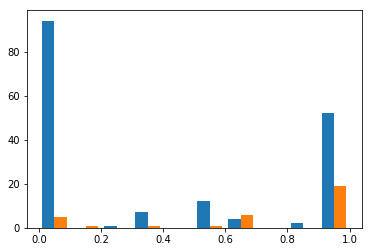

In [52]:
to_plot = full_data[(full_data['SexChild'] == 0) & (full_data['Group Survival'] >= 0)]

plt.hist([to_plot[to_plot['Survived'] == 0]['Group Survival'], to_plot[to_plot['Survived'] == 1]['Group Survival']])

([array([27.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 68.]),
  array([ 2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 20.])],
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 Lists of Patches objects>)

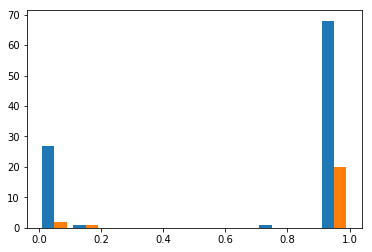

In [53]:
to_plot = full_data[(full_data['SexChild'] == 0) & (full_data['Group FC Survival'] >= 0)]

plt.hist([to_plot[to_plot['Survived'] == 0]['Group FC Survival'], to_plot[to_plot['Survived'] == 1]['Group FC Survival']])

In [54]:
to_plot[(to_plot['Survived'] == 1) & (to_plot['Group FC Survival'] == 0)][['Last Name', 'Ticket']]

,Last Name,Ticket
207,Albimona,2699
579,Jussila,STON/O 2. 3101286
